In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import math

torch.set_default_dtype(torch.float) # Default to float32 initially, can be changed per experiment


In [ ]:
import torch
import torch.nn as nn

class RawAttention(nn.Module):
    def __init__(self, d_model):
        super().__init__()
        self.d_model = d_model

        self.Wq = nn.Linear(d_model, d_model, bias=False)
        self.Wk = nn.Linear(d_model, d_model, bias=False)
        self.Wv = nn.Linear(d_model, d_model, bias=False)

    def forward(self, x):
        # x: (batch, seq_len, d_model)

        Q = self.Wq(x)
        K = self.Wk(x)
        V = self.Wv(x)

        scores = torch.matmul(Q, K.transpose(1, 2)) / (self.d_model ** 0.5)

        out = torch.matmul(scores, V)
        # (batch, seq_len, d_model)

        return out


class RawAttentionWithTopNeuron(nn.Module):
    def __init__(self, d_model,seq_len):
        super().__init__()
        self.raw_attention = RawAttention(d_model)
        self.readout = nn.Linear(d_model*seq_len, 1, bias=True)
        self.seq_len = seq_len

    def forward(self, x):
        # x: (batch, seq_len, d_model)

        attended = self.raw_attention(x)

        # Residual
        combined = attended + x



        # Pool over tokens
        #pooled = combined.sum(dim=1)
        # (batch, d_model)

        out = self.readout(combined.reshape(combined.shape[0], -1))
        # (batch, 1)

        return out


In [ ]:

torch.manual_seed(0)

# -----------------------------
# Example data
# -----------------------------
# Shape: (batch, 9)
X_digits = torch.tensor([
    [1, 2, 3, 4, 5, 6, 7, 8, 9],  # valid
    [1, 2, 8, 4, 5, 6, 3, 8, 7],  # duplicate 8, missing 9
    [9, 8, 7, 6, 5, 4, 3, 2, 1],  # valid
    [1, 7, 2, 3, 4, 5, 6, 1, 8],  # duplicate 1, missing 9
], dtype=torch.long)

y = torch.tensor([
    [1.],
    [0.],
    [1.],
    [0.]
])

# One-hot encode digits 1..9 → indices 0..8
X_onehot = torch.nn.functional.one_hot(X_digits - 1, num_classes=9)
X_onehot = X_onehot.float()
# Shape: (batch, 9, 9)

In [ ]:
# -----------------------------
# Model, loss, optimizer
# -----------------------------

d_model = 9
seq_len = 9
model = RawAttentionWithTopNeuron(d_model, seq_len)

loss_fn = nn.MSELoss()
loss_history = []
optimizer = optim.AdamW(model.parameters(), lr=0.03)

In [ ]:

#optimizer = optim.AdamW(model.parameters(), lr=0.03)

In [ ]:
with torch.no_grad():
    for p in model.parameters():
        p.add_(0.1 * torch.randn_like(p))


In [ ]:
#optimizer = optim.SGD(model.parameters(), lr=0.1e-2)

In [ ]:

# -----------------------------
# Training loop
# -----------------------------
model.train()
epochs = 2000

N = X_train_oh.size(0)
batch_size = N #32

for epoch in range(epochs):
  epoch_loss = 0.0
  epoch_correct = 0.0
  epoch_total = 0.0
  epoch_loss_mean = 0.0

  perm = torch.randperm(N)

  for i in range(0, N, batch_size):
      idx = perm[i:i + batch_size]
      X_use = X_train_oh#[idx]
      y_use = y_train#[idx]
      optimizer.zero_grad()

      preds = model(X_use)   # (batch, 1)
      loss = loss_fn(preds, y_use)



      loss.backward()
      #for name, param in model.named_parameters():
        #print(name, param.grad.norm().item())

      optimizer.step()


      with torch.no_grad():
        preds_bin = (preds > 0.5).float()
        epoch_loss += loss.item()*y_use.size(0)
        epoch_correct += (preds_bin == y_use).sum().item()
        epoch_total += y_use.size(0)

  epoch_loss_mean = epoch_loss / epoch_total
  epoch_acc = epoch_correct / epoch_total
  print("epoch total: ", epoch_total)
  loss_history.append(epoch_loss_mean) # Store loss
  if epoch % 1 == 0:
        print(
            f"Epoch {epoch:3d} | "
            f"Loss: {epoch_loss_mean:.8f} | "
            f"Acc: {epoch_acc:.8f} | "
        )



epoch total:  2177.0
Epoch   0 | Loss: 0.11191317 | Acc: 0.98484153 | 
epoch total:  2177.0
Epoch   1 | Loss: 0.15096729 | Acc: 0.74368397 | 
epoch total:  2177.0
Epoch   2 | Loss: 0.12983193 | Acc: 0.79099678 | 
epoch total:  2177.0
Epoch   3 | Loss: 0.09223104 | Acc: 0.89021589 | 
epoch total:  2177.0
Epoch   4 | Loss: 0.08849593 | Acc: 0.94901240 | 
epoch total:  2177.0
Epoch   5 | Loss: 0.09685661 | Acc: 0.97243914 | 
epoch total:  2177.0
Epoch   6 | Loss: 0.09264398 | Acc: 0.97611392 | 
epoch total:  2177.0
Epoch   7 | Loss: 0.08515169 | Acc: 0.96508957 | 
epoch total:  2177.0
Epoch   8 | Loss: 0.08270983 | Acc: 0.94212219 | 
epoch total:  2177.0
Epoch   9 | Loss: 0.08422402 | Acc: 0.91410198 | 
epoch total:  2177.0
Epoch  10 | Loss: 0.08532810 | Acc: 0.89848415 | 
epoch total:  2177.0
Epoch  11 | Loss: 0.08410768 | Acc: 0.90583372 | 
epoch total:  2177.0
Epoch  12 | Loss: 0.08249054 | Acc: 0.91548002 | 
epoch total:  2177.0
Epoch  13 | Loss: 0.08237256 | Acc: 0.93155719 | 
epoch 

In [ ]:
model.train()

optimizer = torch.optim.LBFGS(
    model.parameters(),
    lr=1.0,
    max_iter=20,
    history_size=100,
    line_search_fn="strong_wolfe"
)

loss_history = []

def closure():
    optimizer.zero_grad()
    preds = model(X_train_oh)
    loss = loss_fn(preds, y_train)
    loss.backward()
    return loss

steps = 400  # NOT epochs

for step in range(steps):
    loss = optimizer.step(closure)

    with torch.no_grad():
        preds = model(X_train_oh)
        preds_bin = (preds > 0.5).float()
        acc = (preds_bin == y_train).float().mean().item()

    loss_history.append(loss.item())

    print(
        f"Step {step:2d} | "
        f"Loss: {loss.item():.8f} | "
        f"Acc: {acc:.8f}"
    )


Step  0 | Loss: 0.06070841 | Acc: 0.95406520
Step  1 | Loss: 0.06070729 | Acc: 0.95406520
Step  2 | Loss: 0.06070570 | Acc: 0.95360589
Step  3 | Loss: 0.06070365 | Acc: 0.95314652
Step  4 | Loss: 0.06070105 | Acc: 0.95268720
Step  5 | Loss: 0.06069775 | Acc: 0.95314652
Step  6 | Loss: 0.06069623 | Acc: 0.95222783
Step  7 | Loss: 0.06069460 | Acc: 0.95176852
Step  8 | Loss: 0.06069266 | Acc: 0.95268720
Step  9 | Loss: 0.06068936 | Acc: 0.95314652
Step 10 | Loss: 0.06068397 | Acc: 0.95268720
Step 11 | Loss: 0.06067901 | Acc: 0.95222783
Step 12 | Loss: 0.06067568 | Acc: 0.95360589
Step 13 | Loss: 0.06067249 | Acc: 0.95406520
Step 14 | Loss: 0.06066980 | Acc: 0.95406520
Step 15 | Loss: 0.06066763 | Acc: 0.95360589
Step 16 | Loss: 0.06066542 | Acc: 0.95406520
Step 17 | Loss: 0.06066350 | Acc: 0.95406520
Step 18 | Loss: 0.06066067 | Acc: 0.95452458
Step 19 | Loss: 0.06065695 | Acc: 0.95452458
Step 20 | Loss: 0.06065372 | Acc: 0.95452458
Step 21 | Loss: 0.06065097 | Acc: 0.95498395
Step 22 | 

In [ ]:
model.train()

loss_history = []
steps = 400  # NOT epochs

for step in range(steps):

    # ---- Forward ----
    model.zero_grad()
    preds = model(X_train_oh)
    loss = loss_fn(preds, y_train)

    # ---- Backward ----
    loss.backward()

    # ---- YOUR UPDATE RULE ----
    with torch.no_grad():
        grad_norm_sq = 0.0

        # Compute ||grad||^2 over ALL parameters
        for p in model.parameters():
            if p.grad is not None:
                grad_norm_sq += torch.sum(p.grad ** 2)

        # Safety guard (very important)
        if grad_norm_sq < 1e-12:
            print("Gradient vanished — stopping.")
            break

        step_scale = loss / grad_norm_sq

        for p in model.parameters():
            if p.grad is not None:
                p -= step_scale * p.grad
    # --------------------------

    # ---- Metrics ----
    with torch.no_grad():
        preds = model(X_train_oh)
        preds_bin = (preds > 0.5).float()
        acc = (preds_bin == y_train).float().mean().item()

    loss_history.append(loss.item())

    print(
        f"Step {step:3d} | "
        f"Loss: {loss.item():.8f} | "
        f"Acc: {acc:.8f}"
    )


NameError: name 'X_train_oh' is not defined

In [ ]:
with torch.no_grad():
    y_hat = model(X_train_oh)
    mse = ((y_hat - y_train)**2)
    print("mean mse:", mse.mean().item())
    print("median mse:", mse.median().item())
    print("max mse:", mse.max().item())


mean mse: 0.06053752452135086
median mse: 0.021217403933405876
max mse: 0.7127650380134583


In [ ]:
num_params = sum(p.numel() for p in model.parameters())
print(num_params)
for name, param in model.named_parameters():
    #if param.grad is not None:
        print(name, param.norm().item(), param.grad.norm().item())


325
raw_attention.Wq.weight 6.249271392822266 0.001194161712191999
raw_attention.Wk.weight 6.048226356506348 0.0011248550144955516
raw_attention.Wv.weight 6.462733745574951 0.0010300666326656938
readout.weight 2.786839723587036 0.0032262157183140516
readout.bias 0.4663619101047516 0.0001569027081131935


In [ ]:
print("\nAnalyzing misclassified training examples from training data:")
model.eval() # Set the model to evaluation mode
with torch.no_grad(): # Disable gradient tracking
    final_preds = model(X_train_oh)
    final_preds_bin = (final_preds > 0.5).float()
    incorrect_indices = (final_preds_bin != y_train).nonzero(as_tuple=True)[0]

    if len(incorrect_indices) == 0:
        print("All training examples were predicted correctly!")
    else:
        print(f"Misclassified training examples {len(incorrect_indices)}:")
        for i in incorrect_indices:
            original_input = X_train[i].tolist() # Get original digits, not one-hot
            predicted_value = final_preds[i].item()
            true_label = y_train[i].item()
            print(f"Input: {original_input}, Predicted: {predicted_value:.4f}, Actual: {int(true_label)}")


Analyzing misclassified training examples from training data:
Misclassified training examples 100:
Input: [1, 7, 5, 8, 6, 9, 3, 1, 2], Predicted: 0.5912, Actual: 0
Input: [9, 4, 7, 3, 1, 9, 6, 2, 7], Predicted: 0.6631, Actual: 0
Input: [6, 7, 6, 7, 4, 2, 9, 1, 3], Predicted: 0.6561, Actual: 0
Input: [5, 1, 9, 7, 6, 2, 8, 5, 4], Predicted: 0.5984, Actual: 0
Input: [8, 1, 8, 5, 3, 7, 6, 9, 2], Predicted: 0.8380, Actual: 0
Input: [5, 6, 8, 2, 5, 3, 1, 6, 3], Predicted: 0.6360, Actual: 0
Input: [8, 2, 5, 3, 7, 1, 8, 7, 6], Predicted: 0.5696, Actual: 0
Input: [2, 1, 4, 9, 7, 8, 8, 5, 3], Predicted: 0.6716, Actual: 0
Input: [4, 8, 6, 5, 8, 7, 9, 2, 9], Predicted: 0.5618, Actual: 0
Input: [5, 4, 2, 8, 3, 5, 7, 8, 6], Predicted: 0.5424, Actual: 0
Input: [1, 3, 6, 9, 1, 4, 5, 8, 6], Predicted: 0.5702, Actual: 0
Input: [9, 5, 9, 5, 6, 1, 8, 3, 2], Predicted: 0.6559, Actual: 0
Input: [1, 5, 7, 5, 4, 3, 4, 9, 8], Predicted: 0.5160, Actual: 0
Input: [6, 4, 4, 2, 5, 9, 1, 6, 5], Predicted: 0.5013, 

In [ ]:
print('Learned Parameters:')
for name, param in model.named_parameters():
    print(f'Parameter: {name}, Value: {param.data}')

Learned Parameters:
Parameter: raw_attention.Wq.weight, Value: tensor([[ 0.5477, -0.0366,  0.1062, -0.7744, -0.4338, -0.4307,  0.7363,  0.0732,
         -0.1985],
        [-0.1114,  0.7091, -0.3124,  0.5589, -0.4155, -0.6528,  0.4183, -0.5023,
          0.0408],
        [ 0.5418,  0.4839, -0.9124, -0.2684,  0.1241,  0.0243,  0.0832,  1.2510,
         -0.4712],
        [-0.5264,  0.5337,  0.8134, -0.3640, -0.4603,  0.1032, -0.1016,  0.0036,
         -0.3987],
        [-0.5089,  0.4652,  0.2729, -0.6537,  0.8158, -0.4725, -0.4494, -0.0639,
          0.7105],
        [ 0.1830,  0.6322, -1.0218, -0.2257,  0.4617,  0.3037,  0.4557, -0.6404,
         -0.3768],
        [ 0.3750,  0.0022, -0.5381,  0.0483,  0.0513, -0.6253, -0.7698,  0.4334,
          0.4935],
        [ 0.7165, -0.1155,  1.1301, -0.1698,  0.3438,  0.3168, -0.5389, -0.1317,
         -0.5720],
        [ 0.1692,  0.3521, -0.6486, -0.0646, -0.6996,  0.3671, -0.0946, -0.1256,
          0.8814]])
Parameter: raw_attention.Wk.weight, 

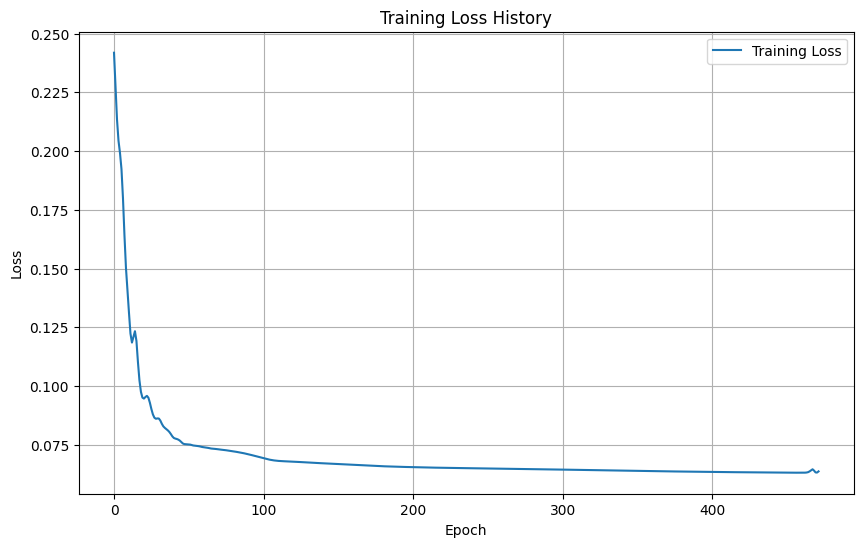

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
#plt.plot(loss_history[:1500], label='Training Loss')
#plt.plot(loss_history[200:], label='Training Loss')
plt.plot(loss_history[10:], label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss History')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import numpy as np

losses = np.array(loss_history)
THRESHOLD = 0.001

# Find first epoch where loss goes below threshold
below_idx = np.where(losses <= THRESHOLD)[0]

if len(below_idx) == 0:
    print("Loss never reached threshold.")
else:
    start = below_idx[0]

    max_after = losses[start:].max()
    print("Max value after threshold: ",max_after)

    increases = np.where(losses[start+1:] > losses[start:-1])[0]

    if len(increases) == 0:
        print("No loss increases after convergence.")
    else:
        print(f"Loss increased {len(increases)} times after reaching {THRESHOLD}.")
        for i in increases[:10]:  # show first few
            e = start + i + 1
            print(
                f"Epoch {e}: "
                f"{losses[e-1]:.6f} → {losses[e]:.6f}"
            )


Max value after threshold:  0.0028853071853518486
Loss increased 118 times after reaching 0.001.
Epoch 43: 0.000404 → 0.001222
Epoch 44: 0.001222 → 0.002254
Epoch 45: 0.002254 → 0.002885
Epoch 51: 0.001317 → 0.001438
Epoch 52: 0.001438 → 0.001477
Epoch 57: 0.000050 → 0.000065
Epoch 58: 0.000065 → 0.000280
Epoch 59: 0.000280 → 0.000492
Epoch 60: 0.000492 → 0.000550
Epoch 64: 0.000298 → 0.000363


In [ ]:
import torch
import itertools
import random

torch.manual_seed(0)
random.seed(0)

# -----------------------------
# Parameters
# -----------------------------
num_symbols = 9
train_frac = 0.003

# -----------------------------
# Generate ALL valid permutations
# -----------------------------
valid_sequences = list(itertools.permutations(range(1, num_symbols + 1)))
valid_labels = [1.0] * len(valid_sequences)

# -----------------------------
# Generate invalid sequences
# -----------------------------
def generate_invalid(num_samples):
    invalid = set()
    while len(invalid) < num_samples:
        seq = [random.randint(1, num_symbols) for _ in range(num_symbols)]
        if len(set(seq)) != num_symbols:  # invalid condition
            invalid.add(tuple(seq))
    return list(invalid)

num_invalid = len(valid_sequences)
invalid_sequences = generate_invalid(num_invalid)
invalid_labels = [0.0] * num_invalid

# -----------------------------
# Combine & shuffle
# -----------------------------
all_sequences = valid_sequences + invalid_sequences
all_labels = valid_labels + invalid_labels

combined = list(zip(all_sequences, all_labels))
random.shuffle(combined)

# -----------------------------
# Train / validation split
# -----------------------------
split_idx = int(len(combined) * train_frac)

train_data = combined[:split_idx]
val_data   = combined[split_idx:]

# -----------------------------
# Ensure NO overlap (sanity check)
# -----------------------------
train_set = set(seq for seq, _ in train_data)
val_set   = set(seq for seq, _ in val_data)

assert train_set.isdisjoint(val_set), "Train / validation overlap detected!"

# -----------------------------
# Convert to tensors
# -----------------------------
def to_tensors(data):
    X = torch.tensor([seq for seq, _ in data], dtype=torch.long)
    y = torch.tensor([[label] for _, label in data], dtype=torch.float)
    return X, y

X_train, y_train = to_tensors(train_data)
X_val,   y_val   = to_tensors(val_data)

# -----------------------------
# One-hot encode
# -----------------------------
X_train_oh = torch.nn.functional.one_hot(X_train - 1, num_classes=num_symbols).float()
X_val_oh   = torch.nn.functional.one_hot(X_val - 1,   num_classes=num_symbols).float()

# -----------------------------
# Final shapes
# -----------------------------
print("Train:", X_train_oh.shape, y_train.shape)
print("Val:  ", X_val_oh.shape, y_val.shape)


Train: torch.Size([2177, 9, 9]) torch.Size([2177, 1])
Val:   torch.Size([723583, 9, 9]) torch.Size([723583, 1])


In [ ]:
model.eval()              # switch to evaluation mode
with torch.no_grad():     # disable gradient tracking
    val_preds = model(X_val_oh)   # (val_batch, 1)
    val_loss = loss_fn(val_preds, y_val)
    val_preds_bin = (val_preds > 0.5).float()
    val_acc = (val_preds_bin == y_val).float().mean()
    print(
            f"Val loss: {val_loss.item():.4f} | "
            f"Val acc: {val_acc.item():.2f}"
        )



Val loss: 0.0966 | Val acc: 0.93


In [ ]:
import torch

# Reproducibility
torch.manual_seed(0)
torch.set_default_dtype(torch.float64)

# Perfect data
x = torch.linspace(-1, 1, 100).unsqueeze(1)
y = 200 * x + 300

# Linear model
model = torch.nn.Linear(1, 1)

# Loss and optimizer
criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)  # try 1e-1, 1e-3

# Training loop
for epoch in range(20000):
    optimizer.zero_grad()
    y_pred = model(x)
    loss = criterion(y_pred, y)
    loss.backward()
    optimizer.step()

    if epoch % 20 == 0:
        w = model.weight.item()
        b = model.bias.item()
        print(f"epoch {epoch:4d} | loss {loss.item():.6f} | w {w:.8f} | b {b:.8f}")


for name, param in model.named_parameters():
    #if param.grad is not None:
        print(name, param.norm().item(), param.grad.norm().item())

epoch    0 | loss 103225.903334 | w 2.29398138 | b 6.40732693
epoch   20 | loss 50257.947006 | w 27.51857569 | b 103.99519101
epoch   40 | loss 25634.777274 | w 49.52485545 | b 169.14562702
epoch   60 | loss 13887.447145 | w 68.72343373 | b 212.64057746
epoch   80 | loss 8063.495225 | w 85.47253500 | b 241.67815310
epoch  100 | loss 5020.104048 | w 100.08467915 | b 261.06387008
epoch  120 | loss 3322.951849 | w 112.83251278 | b 274.00592928
epoch  140 | loss 2307.213005 | w 123.95389653 | b 282.64615117
epoch  160 | loss 1657.129866 | w 133.65634324 | b 288.41443218
epoch  180 | loss 1217.169728 | w 142.12088994 | b 292.26538257
epoch  200 | loss 906.747703 | w 149.50547580 | b 294.83630774
epoch  220 | loss 681.374057 | w 155.94788912 | b 296.55267789
epoch  240 | loss 514.694728 | w 161.56833828 | b 297.69854027
epoch  260 | loss 389.997510 | w 166.47169470 | b 298.46352714
epoch  280 | loss 296.053968 | w 170.74944965 | b 298.97423847
epoch  300 | loss 224.982764 | w 174.48142135 | 

In [ ]:
import torch

# -------------------------------
# Configuration
# -------------------------------
torch.manual_seed(0)
torch.set_default_dtype(torch.float)

N = 400      # number of inputs / weights
SAMPLES = 500
LR = 1e-2
EPOCHS = 60000

# -------------------------------
# Perfect data
# -------------------------------
X = torch.randn(SAMPLES, N)
true_w = torch.tensor([200.0 + i for i in range(N)])
y = X @ true_w

# -------------------------------
# Linear model
# -------------------------------
model = torch.nn.Linear(N, 1, bias=True)

criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LR)
#optimizer = torch.optim.LBFGS(model.parameters(), lr=1.0)


# -------------------------------
# Training loop
# -------------------------------
for epoch in range(EPOCHS):
    optimizer.zero_grad()
    y_pred = model(X).squeeze()
    loss = criterion(y_pred, y)
    loss.backward()
    optimizer.step()

    if epoch % 500 == 0:
        max_err = (model.weight.squeeze() - true_w).abs().max().item()
        print(f"epoch {epoch:4d} | loss {loss.item():.8f} | max weight error {max_err:.8f}")

# -------------------------------
# Final result
# -------------------------------
print("\nTrue weights:")
print(true_w)

print("\nLearned weights:")
print(model.weight.detach().squeeze())

for name, param in model.named_parameters():
    #if param.grad is not None:
        print(name, param.norm().item(), param.grad.norm().item())

TypeError: LBFGS.step() missing 1 required positional argument: 'closure'

In [ ]:
import torch

torch.manual_seed(0)
torch.set_default_dtype(torch.float)

N = 400
SAMPLES = 500

X = torch.randn(SAMPLES, N)
true_w = torch.tensor([200.0 + i for i in range(N)])
y = X @ true_w

model = torch.nn.Linear(N, 1, bias=True)
criterion = torch.nn.MSELoss()

optimizer = torch.optim.LBFGS(
    model.parameters(),
    lr=1.0,                 # not a "learning rate" in the SGD sense
    max_iter=20,            # iterations per step()
    history_size=100,
    line_search_fn="strong_wolfe"
)

def closure():
    optimizer.zero_grad()
    y_pred = model(X).squeeze()
    loss = criterion(y_pred, y)
    loss.backward()
    return loss

# Run a few outer steps
for step in range(10):
    loss = optimizer.step(closure)
    max_err = (model.weight.squeeze() - true_w).abs().max().item()
    print(f"step {step:2d} | loss {loss.item():.3e} | max weight error {max_err:.3e}")


step  0 | loss 6.776e+07 | max weight error 1.265e+02
step  1 | loss 1.837e+04 | max weight error 1.980e+01
step  2 | loss 4.116e+02 | max weight error 2.714e+00
step  3 | loss 6.664e+00 | max weight error 1.740e-01
step  4 | loss 4.076e-02 | max weight error 1.755e-02
step  5 | loss 2.904e-04 | max weight error 3.113e-03
step  6 | loss 1.044e-05 | max weight error 1.572e-03
step  7 | loss 3.825e-06 | max weight error 1.572e-03
step  8 | loss 3.825e-06 | max weight error 1.572e-03
step  9 | loss 3.825e-06 | max weight error 1.572e-03


# Task
```python
import torch
import torch.nn as nn
import torch.optim as optim
import math
import itertools
import random
import matplotlib.pyplot as plt
import numpy as np

# Set default dtype for consistency
torch.set_default_dtype(torch.float)
torch.manual_seed(0)
random.seed(0)

# --- 1. Encapsulate Model Definition ---
class RawAttention(nn.Module):
    def __init__(self, d_model):
        super().__init__()
        self.d_model = d_model
        self.Wq = nn.Linear(d_model, d_model, bias=False)
        self.Wk = nn.Linear(d_model, d_model, bias=False)
        self.Wv = nn.Linear(d_model, d_model, bias=False)

    def forward(self, x):
        Q = self.Wq(x)
        K = self.Wk(x)
        V = self.Wv(x)
        scores = torch.matmul(Q, K.transpose(1, 2)) / (self.d_model ** 0.5)
        out = torch.matmul(scores, V)
        return out

class RawAttentionWithTopNeuron(nn.Module):
    def __init__(self, d_model, seq_len):
        super().__init__()
        self.raw_attention = RawAttention(d_model)
        self.readout = nn.Linear(d_model * seq_len, 1, bias=True)
        self.seq_len = seq_len

    def forward(self, x):
        attended = self.raw_attention(x)
        combined = attended + x  # Residual
        out = self.readout(combined.reshape(combined.shape[0], -1))
        return out

def initialize_model_and_loss(d_model, seq_len):
    """Initializes the model and loss function."""
    model = RawAttentionWithTopNeuron(d_model, seq_len)
    loss_fn = nn.MSELoss()
    return model, loss_fn

# --- 2. Consolidate Data Generation ---
def generate_data(num_symbols=9, train_frac=0.003, seed=0):
    """
    Generates training and validation data for the permutation task.

    Args:
        num_symbols (int): The number of symbols (e.g., 9 for digits 1-9).
        train_frac (float): The fraction of data to use for training.
        seed (int): Random seed for reproducibility.

    Returns:
        tuple: (X_train_oh, y_train, X_val_oh, y_val, X_train_original, X_val_original)
               where _oh refers to one-hot encoded and _original refers to non-one-hot.
    """
    torch.manual_seed(seed)
    random.seed(seed)

    # Generate ALL valid permutations
    valid_sequences = list(itertools.permutations(range(1, num_symbols + 1)))
    valid_labels = [1.0] * len(valid_sequences)

    # Generate invalid sequences
    invalid = set()
    num_invalid = len(valid_sequences) # Keep balance of valid/invalid for now
    while len(invalid) < num_invalid:
        seq = [random.randint(1, num_symbols) for _ in range(num_symbols)]
        if len(set(seq)) != num_symbols:  # invalid condition
            invalid.add(tuple(seq))
    invalid_sequences = list(invalid)
    invalid_labels = [0.0] * len(invalid_sequences)

    # Combine & shuffle
    all_sequences = valid_sequences + invalid_sequences
    all_labels = valid_labels + invalid_labels
    combined = list(zip(all_sequences, all_labels))
    random.shuffle(combined)

    # Train / validation split
    split_idx = int(len(combined) * train_frac)
    train_data = combined[:split_idx]
    val_data = combined[split_idx:]

    # Convert to tensors
    def to_tensors(data):
        X = torch.tensor([seq for seq, _ in data], dtype=torch.long)
        y = torch.tensor([[label] for _, label in data], dtype=torch.float)
        return X, y

    X_train_original, y_train = to_tensors(train_data)
    X_val_original, y_val = to_tensors(val_data)

    # One-hot encode
    X_train_oh = torch.nn.functional.one_hot(X_train_original - 1, num_classes=num_symbols).float()
    X_val_oh = torch.nn.functional.one_hot(X_val_original - 1, num_classes=num_symbols).float()

    print(f"Data generated with {num_symbols} symbols, train_frac={train_frac}:")
    print("  Train:", X_train_oh.shape, y_train.shape)
    print("  Val:  ", X_val_oh.shape, y_val.shape)
    return X_train_oh, y_train, X_val_oh, y_val, X_train_original, X_val_original

# --- 3. Create Reusable Training Function ---
def train_model(model, optimizer, loss_fn, X_train_oh, y_train, X_val_oh=None, y_val=None,
                epochs=100, batch_size=None, optimizer_type='adamw', custom_update_fn=None,
                log_interval=100, log_verbose=True):
    """
    Trains the model and records loss history.

    Args:
        model (nn.Module): The model to train.
        optimizer (torch.optim.Optimizer): The optimizer to use.
        loss_fn (nn.Module): The loss function.
        X_train_oh (torch.Tensor): One-hot encoded training features.
        y_train (torch.Tensor): Training labels.
        X_val_oh (torch.Tensor, optional): One-hot encoded validation features.
        y_val (torch.Tensor, optional): Validation labels.
        epochs (int): Number of training epochs/steps.
        batch_size (int, optional): Batch size for training. If None, uses full batch.
        optimizer_type (str): 'adamw', 'lbfgs', or 'custom'.
        custom_update_fn (callable, optional): A function for custom parameter updates.
                                               Expected signature: custom_update_fn(model, loss)
        log_interval (int): How often to print training progress.
        log_verbose (bool): Whether to print detailed logs.

    Returns:
        list: List of training loss values per epoch/step.
    """
    model.train()
    loss_history = []
    N = X_train_oh.size(0)
    batch_size = batch_size if batch_size is not None else N

    for epoch in range(epochs):
        epoch_loss = 0.0
        epoch_correct = 0.0
        epoch_total = 0.0

        if optimizer_type == 'lbfgs':
            # LBFGS uses a closure
            def closure():
                optimizer.zero_grad()
                preds = model(X_train_oh)
                loss = loss_fn(preds, y_train)
                loss.backward()
                return loss
            loss = optimizer.step(closure)
            current_loss = loss.item()
            # Calculate accuracy for LBFGS outside closure
            with torch.no_grad():
                preds = model(X_train_oh)
                preds_bin = (preds > 0.5).float()
                acc = (preds_bin == y_train).float().mean().item()
            epoch_loss = current_loss
            epoch_correct = acc * N
            epoch_total = N
            loss_history.append(current_loss)

        elif optimizer_type == 'custom':
            model.zero_grad()
            preds = model(X_train_oh)
            loss = loss_fn(preds, y_train)
            loss.backward()
            if custom_update_fn:
                custom_update_fn(model, loss)
            current_loss = loss.item()
            # Calculate accuracy for custom update
            with torch.no_grad():
                preds_bin = (preds > 0.5).float()
                acc = (preds_bin == y_train).float().mean().item()
            epoch_loss = current_loss
            epoch_correct = acc * N
            epoch_total = N
            loss_history.append(current_loss)

        else: # AdamW, SGD, etc.
            perm = torch.randperm(N)
            for i in range(0, N, batch_size):
                idx = perm[i:i + batch_size]
                X_batch = X_train_oh[idx]
                y_batch = y_train[idx]

                optimizer.zero_grad()
                preds = model(X_batch)
                loss = loss_fn(preds, y_batch)
                loss.backward()
                optimizer.step()

                with torch.no_grad():
                    preds_bin = (preds > 0.5).float()
                    epoch_loss += loss.item() * y_batch.size(0)
                    epoch_correct += (preds_bin == y_batch).sum().item()
                    epoch_total += y_batch.size(0)
            
            current_loss = epoch_loss / epoch_total
            loss_history.append(current_loss)


        if log_verbose and epoch % log_interval == 0:
            if epoch_total > 0:
                print(
                    f"Epoch {epoch:4d} | "
                    f"Loss: {current_loss:.8f} | "
                    f"Acc: {epoch_correct / epoch_total:.8f}"
                )
            else:
                print(f"Epoch {epoch:4d} | Loss: {current_loss:.8f}")

    return loss_history

# --- 4. Create Reusable Evaluation Function ---
def evaluate_model(model, loss_fn, X_data_oh, y_data, X_data_original=None, data_name="Validation"):
    """
    Evaluates the model's performance on a given dataset.

    Args:
        model (nn.Module): The trained model.
        loss_fn (nn.Module): The loss function.
        X_data_oh (torch.Tensor): One-hot encoded features of the dataset.
        y_data (torch.Tensor): Labels of the dataset.
        X_data_original (torch.Tensor, optional): Original (non-one-hot) features for logging misclassified examples.
        data_name (str): Name of the dataset (e.g., "Training", "Validation").

    Returns:
        tuple: (loss, accuracy)
    """
    model.eval()
    with torch.no_grad():
        preds = model(X_data_oh)
        loss = loss_fn(preds, y_data)
        preds_bin = (preds > 0.5).float()
        correct = (preds_bin == y_data).sum().item()
        total = y_data.size(0)
        accuracy = correct / total

        print(
            f"{data_name} results | "
            f"Loss: {loss.item():.4f} | "
            f"Acc: {accuracy:.4f}"
        )

        if X_data_original is not None:
            incorrect_indices = (preds_bin != y_data).nonzero(as_tuple=True)[0]
            if len(incorrect_indices) > 0:
                print(f"\nAnalyzing misclassified {data_name} examples ({len(incorrect_indices)} total):")
                for i in incorrect_indices[:5]: # Show up to 5 misclassified examples
                    original_input = X_data_original[i].tolist()
                    predicted_value = preds[i].item()
                    true_label = y_data[i].item()
                    print(f"  Input: {original_input}, Predicted: {predicted_value:.4f}, Actual: {int(true_label)}")
            else:
                print(f"\nAll {data_name} examples predicted correctly!")
    return loss.item(), accuracy

# Custom update rule function
def custom_gradient_update(model, loss):
    """Applies a custom gradient update rule."""
    with torch.no_grad():
        grad_norm_sq = 0.0
        for p in model.parameters():
            if p.grad is not None:
                grad_norm_sq += torch.sum(p.grad ** 2)

        if grad_norm_sq < 1e-12:
            print("Gradient vanished — skipping update.")
            return

        step_scale = loss / grad_norm_sq

        for p in model.parameters():
            if p.grad is not None:
                p -= step_scale * p.grad

# --- Demonstrate Usage with Different Optimizers ---
print("--- Training with AdamW Optimizer ---")
d_model = 9
seq_len = 9
X_train_oh_adamw, y_train_adamw, X_val_oh_adamw, y_val_adamw, X_train_original_adamw, X_val_original_adamw = generate_data(num_symbols=9, train_frac=0.003, seed=42)
model_adamw, loss_fn_adamw = initialize_model_and_loss(d_model, seq_len)
optimizer_adamw = optim.AdamW(model_adamw.parameters(), lr=0.03)
adamw_loss_history = train_model(model_adamw, optimizer_adamw, loss_fn_adamw, X_train_oh_adamw, y_train_adamw,
                                 epochs=500, log_interval=100, optimizer_type='adamw')
evaluate_model(model_adamw, loss_fn_adamw, X_val_oh_adamw, y_val_adamw, X_val_original_adamw, data_name="Validation (AdamW)")

print("\n--- Training with LBFGS Optimizer ---")
X_train_oh_lbfgs, y_train_lbfgs, X_val_oh_lbfgs, y_val_lbfgs, X_train_original_lbfgs, X_val_original_lbfgs = generate_data(num_symbols=9, train_frac=0.003, seed=43)
model_lbfgs, loss_fn_lbfgs = initialize_model_and_loss(d_model, seq_len)
optimizer_lbfgs = torch.optim.LBFGS(model_lbfgs.parameters(), lr=1.0, max_iter=20, history_size=100, line_search_fn="strong_wolfe")
lbfgs_loss_history = train_model(model_lbfgs, optimizer_lbfgs, loss_fn_lbfgs, X_train_oh_lbfgs, y_train_lbfgs,
                                 epochs=400, optimizer_type='lbfgs', log_interval=100) # LBFGS steps are not epochs, usually fewer steps
evaluate_model(model_lbfgs, loss_fn_lbfgs, X_val_oh_lbfgs, y_val_lbfgs, X_val_original_lbfgs, data_name="Validation (LBFGS)")


print("\n--- Training with Custom Optimizer (Gradient Normalization) ---")
X_train_oh_custom, y_train_custom, X_val_oh_custom, y_val_custom, X_train_original_custom, X_val_original_custom = generate_data(num_symbols=9, train_frac=0.003, seed=44)
model_custom, loss_fn_custom = initialize_model_and_loss(d_model, seq_len)
custom_loss_history = train_model(model_custom, None, loss_fn_custom, X_train_oh_custom, y_train_custom,
                                  epochs=500, optimizer_type='custom', custom_update_fn=custom_gradient_update, log_interval=100)
evaluate_model(model_custom, loss_fn_custom, X_val_oh_custom, y_val_custom, X_val_original_custom, data_name="Validation (Custom)")


# --- Demonstrate Usage with Different Input Data Parameters ---
print("\n--- Training with Different Data Parameters (AdamW, 5 symbols) ---")
d_model_small = 5
seq_len_small = 5
X_train_oh_small, y_train_small, X_val_oh_small, y_val_small, X_train_original_small, X_val_original_small = generate_data(num_symbols=d_model_small, train_frac=0.1, seed=45)
model_small, loss_fn_small = initialize_model_and_loss(d_model_small, seq_len_small)
optimizer_small = optim.AdamW(model_small.parameters(), lr=0.01)
small_data_loss_history = train_model(model_small, optimizer_small, loss_fn_small, X_train_oh_small, y_train_small,
                                      epochs=300, log_interval=50, optimizer_type='adamw')
evaluate_model(model_small, loss_fn_small, X_val_oh_small, y_val_small, X_val_original_small, data_name="Validation (Small Data)")


# --- Visualize Training History ---
plt.figure(figsize=(12, 8))
plt.plot(adamw_loss_history, label='AdamW Loss', alpha=0.7)
plt.plot(lbfgs_loss_history, label='LBFGS Loss', alpha=0.7)
plt.plot(custom_loss_history, label='Custom Update Loss', alpha=0.7)
plt.plot(small_data_loss_history, label='AdamW (5 Symbols) Loss', alpha=0.7, linestyle='--')
plt.xlabel('Epoch/Step')
plt.ylabel('Loss')
plt.title('Training Loss History for Different Optimizers and Data Parameters')
plt.legend()
plt.grid(True)
plt.yscale('log') # Use log scale for better visualization of different convergence speeds
plt.show()

# --- Final Task: Summary ---
print("\n--- Summary of Organized Code Structure ---")
print("The code has been refactored into modular functions:")
print("1. `generate_data`: Centralized function to create training and validation datasets, ensuring reproducibility and easy modification of data parameters (e.g., number of symbols, train/validation split ratio).")
print("2. `initialize_model_and_loss`: A function to instantiate the `RawAttentionWithTopNeuron` model and the `MSELoss` function, making it easy to configure model size or loss types.")
print("3. `train_model`: A flexible training loop that accommodates different optimizers (AdamW, LBFGS, custom update rules) by handling their specific `step` mechanisms (e.g., LBFGS's `closure`). This allows for straightforward experimentation with various optimization algorithms.")
print("4. `evaluate_model`: A dedicated function to assess model performance on given data, calculating loss and accuracy, and providing insights into misclassified examples. This standardizes the evaluation process.")

print("\n**How this structure facilitates experimentation:**")
print("- **Different Optimizers**: By passing different optimizer instances (e.g., `optim.AdamW`, `torch.optim.LBFGS`) and specifying `optimizer_type`, the same `train_model` function can be used without code duplication, as demonstrated above.")
print("- **Different Input Data Parameters**: The `generate_data` function allows easy generation of datasets with varying `num_symbols` or `train_frac`. This means one can quickly test the model's performance on different problem complexities or dataset sizes, as shown with the 5-symbol example.")
print("- **Clearer Workflow**: The modularity makes the entire machine learning pipeline (data -> model -> train -> evaluate) much clearer, easier to understand, debug, and extend.")
print("- **Reproducibility**: Explicit seeding and function encapsulation promote reproducibility of experiments.")
```

## Consolidate Data Generation

### Subtask:
Create a dedicated function to generate training and validation data (X_train, y_train, X_val, y_val, and their one-hot encoded versions) based on specified parameters (e.g., number of symbols, train_frac). This function will ensure data is generated consistently and can be easily reproduced or modified for different experiments.


**Reasoning**:
I will define a function `generate_data` that encapsulates all the data generation logic, including setting seeds, generating valid and invalid sequences, combining and splitting data, one-hot encoding, and converting to tensors, as per the instructions.



In [ ]:
import itertools
import random

def generate_data(num_symbols=9, train_frac=0.003, seed=0, dtype=torch.float):
    # Set seeds for reproducibility
    torch.manual_seed(seed)
    random.seed(seed)

    # -----------------------------
    # Generate ALL valid permutations
    # -----------------------------
    valid_sequences = list(itertools.permutations(range(1, num_symbols + 1)))
    valid_labels = [1.0] * len(valid_sequences)

    # -----------------------------
    # Generate invalid sequences
    # -----------------------------
    def generate_invalid(num_samples):
        invalid = set()
        while len(invalid) < num_samples:
            seq = [random.randint(1, num_symbols) for _ in range(num_symbols)]
            if len(set(seq)) != num_symbols:  # invalid condition
                invalid.add(tuple(seq))
        return list(invalid)

    num_invalid = len(valid_sequences) # Ensure equal number of valid and invalid for balance
    invalid_sequences = generate_invalid(num_invalid)
    invalid_labels = [0.0] * num_invalid

    # -----------------------------
    # Combine & shuffle
    # -----------------------------
    all_sequences = valid_sequences + invalid_sequences
    all_labels = valid_labels + invalid_labels

    combined = list(zip(all_sequences, all_labels))
    random.shuffle(combined)

    # -----------------------------
    # Train / validation split
    # -----------------------------
    split_idx = int(len(combined) * train_frac)

    train_data = combined[:split_idx]
    val_data   = combined[split_idx:]

    # -----------------------------
    # Ensure NO overlap (sanity check)
    # -----------------------------
    train_set = set(seq for seq, _ in train_data)
    val_set   = set(seq for seq, _ in val_data)

    assert train_set.isdisjoint(val_set), "Train / validation overlap detected!"

    # -----------------------------
    # Convert to tensors
    # -----------------------------
    def to_tensors(data):
        X = torch.tensor([seq for seq, _ in data], dtype=torch.long)
        y = torch.tensor([[label] for _, label in data], dtype=dtype)
        return X, y

    X_train_original, y_train = to_tensors(train_data)
    X_val_original,   y_val   = to_tensors(val_data)

    # -----------------------------
    # One-hot encode
    # -----------------------------
    X_train_oh = torch.nn.functional.one_hot(X_train_original - 1, num_classes=num_symbols).to(dtype=dtype)
    X_val_oh   = torch.nn.functional.one_hot(X_val_original - 1,   num_classes=num_symbols).to(dtype=dtype)

    # -----------------------------
    # Final shapes
    # -----------------------------
    print("Train OH:", X_train_oh.shape, "Train y:", y_train.shape)
    print("Val OH:  ", X_val_oh.shape, "Val y:", y_val.shape)

    return X_train_oh, y_train, X_val_oh, y_val, X_train_original, X_val_original

# Call the function to generate data
X_train_oh, y_train, X_val_oh, y_val, X_train, X_val = generate_data()

Train OH: torch.Size([2177, 9, 9]) Train y: torch.Size([2177, 1])
Val OH:   torch.Size([723583, 9, 9]) Val y: torch.Size([723583, 1])


## Encapsulate Model Definition

### Subtask:
Ensure the model `RawAttentionWithTopNeuron` and its initialization are clearly defined in a separate block or function, allowing for easy re-instantiation with different `d_model` or `seq_len` parameters if needed. This step also includes setting the loss function (`nn.MSELoss`).


**Reasoning**:
I will define the `RawAttention` and `RawAttentionWithTopNeuron` classes and then create the `initialize_model_and_loss` function to encapsulate the model and loss initialization as specified in the instructions. This will make the model definition reusable.



In [ ]:
import torch
import torch.nn as nn

# 1. Define the RawAttention class
class RawAttention(nn.Module):
    def __init__(self, d_model, dtype=torch.float):
        super().__init__()
        self.d_model = d_model
        self.Wq = nn.Linear(d_model, d_model, bias=False, dtype=dtype)
        self.Wk = nn.Linear(d_model, d_model, bias=False, dtype=dtype)
        self.Wv = nn.Linear(d_model, d_model, bias=False, dtype=dtype)

    def forward(self, x):
        Q = self.Wq(x)
        K = self.Wk(x)
        V = self.Wv(x)
        scores = torch.matmul(Q, K.transpose(1, 2)) / (self.d_model ** 0.5)
        out = torch.matmul(scores, V)
        return out

# 2. Define the RawAttentionWithTopNeuron class
class RawAttentionWithTopNeuron(nn.Module):
    def __init__(self, d_model, seq_len, dtype=torch.float):
        super().__init__()
        self.raw_attention = RawAttention(d_model, dtype=dtype)
        self.readout = nn.Linear(d_model * seq_len, 1, bias=True, dtype=dtype)
        self.seq_len = seq_len

    def forward(self, x):
        attended = self.raw_attention(x)
        combined = attended + x  # Residual connection
        out = self.readout(combined.reshape(combined.shape[0], -1))
        return out

# 3. Create a function named initialize_model_and_loss
def initialize_model_and_loss(d_model, seq_len, dtype=torch.float):
    """Initializes the model and loss function."""
    model = RawAttentionWithTopNeuron(d_model, seq_len, dtype=dtype)
    loss_fn = nn.MSELoss()
    return model, loss_fn

print("Model classes and initialization function defined.")

Model classes and initialization function defined.


## Create Reusable Training Function

### Subtask:
Develop a function that encapsulates the training loop logic. This function should accept the model, optimizer, loss function, training data (X_train_oh, y_train), and optional validation data (X_val_oh, y_val). It will handle the forward pass, loss calculation, backward pass, optimizer step, and logging of metrics like loss and accuracy. It should also be flexible enough to accommodate different optimizers like AdamW, LBFGS, or custom update rules.


**Reasoning**:
I will define the `train_model` function as specified, incorporating logic for different optimizer types (AdamW/SGD, LBFGS, custom updates) and handling batching, loss calculation, and logging.



In [ ]:
import torch.optim as optim

def _train_adamw_or_sgd(model, optimizer, loss_fn, X_train_oh, y_train, epochs, batch_size, log_interval, log_verbose):
    loss_history = []
    N = X_train_oh.size(0)

    for epoch in range(epochs):
        epoch_loss = 0.0
        epoch_correct = 0.0
        epoch_total = 0.0

        perm = torch.randperm(N)
        for i in range(0, N, batch_size):
            idx = perm[i:i + batch_size]
            X_batch = X_train_oh[idx]
            y_batch = y_train[idx]

            optimizer.zero_grad()
            preds = model(X_batch)
            loss = loss_fn(preds, y_batch)
            loss.backward()
            optimizer.step()

            with torch.no_grad():
                preds_bin = (preds > 0.5).float()
                epoch_loss += loss.item() * y_batch.size(0)
                epoch_correct += (preds_bin == y_batch).sum().item()
                epoch_total += y_batch.size(0)

        current_loss = epoch_loss / epoch_total if epoch_total > 0 else 0.0
        current_acc = epoch_correct / epoch_total if epoch_total > 0 else 0.0
        loss_history.append(current_loss)

        if log_verbose and epoch % log_interval == 0:
            print(
                f"Epoch {epoch:4d} | "
                f"Loss: {current_loss:.8f} | "
                f"Acc: {current_acc:.8f}"
            )
    return loss_history

def _train_lbfgs(model, optimizer, loss_fn, X_train_oh, y_train, epochs, log_interval, log_verbose):
    loss_history = []
    N = X_train_oh.size(0)

    for epoch in range(epochs):
        def closure():
            optimizer.zero_grad()
            preds = model(X_train_oh)
            loss = loss_fn(preds, y_train)
            loss.backward()
            return loss

        loss = optimizer.step(closure)
        current_loss = loss.item()

        with torch.no_grad():
            preds = model(X_train_oh)
            preds_bin = (preds > 0.5).float()
            current_acc = (preds_bin == y_train).float().mean().item()

        loss_history.append(current_loss)

        if log_verbose and epoch % log_interval == 0:
            print(
                f"Epoch {epoch:4d} | "
                f"Loss: {current_loss:.8f} | "
                f"Acc: {current_acc:.8f}"
            )
    return loss_history

def _train_custom_optimizer(model, custom_update_fn, loss_fn, X_train_oh, y_train, epochs, log_interval, log_verbose):
    loss_history = []
    N = X_train_oh.size(0)

    for epoch in range(epochs):
        model.zero_grad()
        preds = model(X_train_oh)
        loss = loss_fn(preds, y_train)
        loss.backward()
        if custom_update_fn:
            custom_update_fn(model, loss)
        current_loss = loss.item()

        with torch.no_grad():
            preds_bin = (preds > 0.5).float()
            current_acc = (preds_bin == y_train).float().mean().item()

        loss_history.append(current_loss)

        if log_verbose and epoch % log_interval == 0:
            print(
                f"Epoch {epoch:4d} | "
                f"Loss: {current_loss:.8f} | "
                f"Acc: {current_acc:.8f}"
            )
    return loss_history

def train_model(model, optimizer, loss_fn, X_train_oh, y_train, X_val_oh=None, y_val=None,
                epochs=100, batch_size=None, optimizer_type='adamw', custom_update_fn=None,
                log_interval=100, log_verbose=True):
    """
    Trains the model and records loss history.

    Args:
        model (nn.Module): The model to train.
        optimizer (torch.optim.Optimizer): The optimizer to use.
        loss_fn (nn.Module): The loss function.
        X_train_oh (torch.Tensor): One-hot encoded training features.
        y_train (torch.Tensor): Training labels.
        X_val_oh (torch.Tensor, optional): One-hot encoded validation features.
        y_val (torch.Tensor, optional): Validation labels.
        epochs (int): Number of training epochs/steps.
        batch_size (int, optional): Batch size for training. If None, uses full batch.
        optimizer_type (str): 'adamw', 'lbfgs', or 'custom'.
        custom_update_fn (callable, optional): A function for custom parameter updates.
                                               Expected signature: custom_update_fn(model, loss)
        log_interval (int): How often to print training progress.
        log_verbose (bool): Whether to print detailed logs.

    Returns:
        list: List of training loss values per epoch/step.
    """
    model.train()
    N = X_train_oh.size(0)
    batch_size = batch_size if batch_size is not None else N

    if optimizer_type == 'lbfgs':
        return _train_lbfgs(model, optimizer, loss_fn, X_train_oh, y_train, epochs, log_interval, log_verbose)
    elif optimizer_type == 'custom':
        return _train_custom_optimizer(model, custom_update_fn, loss_fn, X_train_oh, y_train, epochs, log_interval, log_verbose)
    else:  # 'adamw', 'sgd', or any other batch-based optimizer
        return _train_adamw_or_sgd(model, optimizer, loss_fn, X_train_oh, y_train, epochs, batch_size, log_interval, log_verbose)

print("Reusable training function `train_model` defined and reorganized.")

Reusable training function `train_model` defined and reorganized.


## Create Reusable Evaluation Function

### Subtask:
Implement a function to evaluate the model's performance on a given dataset (e.g., validation set). This function will take the trained model, evaluation data, and loss function, and return metrics like loss and accuracy. It should also include logic for analyzing misclassified examples, similar to your existing `k0dR0gV_A_bp` cell.


**Reasoning**:
I will define the `evaluate_model` function as specified in the instructions. This function will handle model evaluation, calculate loss and accuracy, and optionally identify and print misclassified examples.



In [ ]:
def evaluate_model(model, loss_fn, X_data_oh, y_data, X_data_original=None, data_name="Validation"):
    """
    Evaluates the model's performance on a given dataset.

    Args:
        model (nn.Module): The trained model.
        loss_fn (nn.Module): The loss function.
        X_data_oh (torch.Tensor): One-hot encoded features of the dataset.
        y_data (torch.Tensor): Labels of the dataset.
        X_data_original (torch.Tensor, optional): Original (non-one-hot) features for logging misclassified examples.
        data_name (str): Name of the dataset (e.g., "Training", "Validation").

    Returns:
        tuple: (loss, accuracy)
    """
    model.eval() # Set the model to evaluation mode
    with torch.no_grad(): # Disable gradient tracking
        preds = model(X_data_oh) # Make predictions
        loss = loss_fn(preds, y_data)
        preds_bin = (preds > 0.5).float() # Binarize predictions

        correct = (preds_bin == y_data).sum().item()
        total = y_data.size(0)
        accuracy = correct / total

        print(
            f"{data_name} results | "
            f"Loss: {loss.item():.4f} | "
            f"Acc: {accuracy:.4f}"
        )

        if X_data_original is not None:
            incorrect_indices = (preds_bin != y_data).nonzero(as_tuple=True)[0]
            if len(incorrect_indices) > 0:
                print(f"\nAnalyzing misclassified {data_name} examples ({len(incorrect_indices)} total):")
                for i in incorrect_indices[:5]: # Show up to 5 misclassified examples
                    original_input = X_data_original[i].tolist()
                    predicted_value = preds[i].item()
                    true_label = y_data[i].item()
                    print(f"  Input: {original_input}, Predicted: {predicted_value:.4f}, Actual: {int(true_label)}")
            else:
                print(f"\nAll {data_name} examples predicted correctly!")

    return loss.item(), accuracy

print("Reusable evaluation function `evaluate_model` defined.")

Reusable evaluation function `evaluate_model` defined.


## Demonstrate Usage with Different Optimizers

### Subtask:
Show how to use the refactored functions to train the model with different optimizers (e.g., AdamW, LBFGS, or your custom update rule) by passing them to the generic training function. This will illustrate the reusability of the new structure.


**Reasoning**:
I will define the `custom_gradient_update` function and then demonstrate the usage of the `generate_data`, `initialize_model_and_loss`, `train_model`, and `evaluate_model` functions with AdamW, LBFGS, and a custom gradient update rule, as specified in the instructions. This will show the reusability and flexibility of the refactored code.



--- Training with AdamW Optimizer (float32) ---
Train OH: torch.Size([2177, 9, 9]) Train y: torch.Size([2177, 1])
Val OH:   torch.Size([723583, 9, 9]) Val y: torch.Size([723583, 1])
Epoch    0 | Loss: 0.68294740 | Acc: 0.50987598
Epoch  100 | Loss: 0.06874266 | Acc: 0.94625632
Epoch  200 | Loss: 0.06179719 | Acc: 0.95406523
Epoch  300 | Loss: 0.06079365 | Acc: 0.95452458
Epoch  400 | Loss: 0.05980706 | Acc: 0.95130914

--- Evaluation for AdamW Model (float32) ---
Validation (AdamW, float32) results | Loss: 0.0957 | Acc: 0.9362

Analyzing misclassified Validation (AdamW, float32) examples (46138 total):
  Input: [6, 9, 7, 8, 8, 7, 5, 2, 3], Predicted: 0.6419, Actual: 0
  Input: [4, 9, 7, 5, 8, 1, 3, 4, 9], Predicted: 0.5976, Actual: 0
  Input: [6, 7, 3, 2, 3, 9, 1, 5, 3], Predicted: 0.5075, Actual: 0
  Input: [6, 2, 6, 9, 3, 1, 4, 5, 9], Predicted: 0.5924, Actual: 0
  Input: [7, 8, 3, 9, 6, 4, 3, 6, 4], Predicted: 0.5652, Actual: 0

--- Training with LBFGS Optimizer (float64) ---
Train 

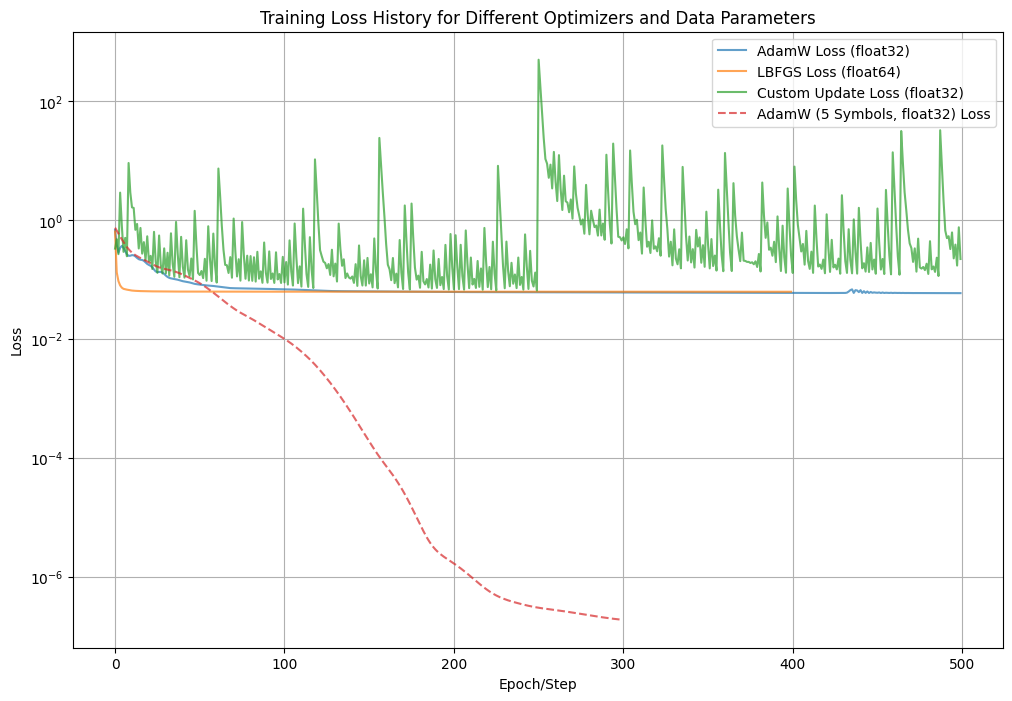


--- Summary of Organized Code Structure ---
The code has been refactored into modular functions:
1. `generate_data`: Centralized function to create training and validation datasets, ensuring reproducibility and easy modification of data parameters (e.g., number of symbols, train/validation split ratio).
2. `initialize_model_and_loss`: A function to instantiate the `RawAttentionWithTopNeuron` model and the `MSELoss` function, making it easy to configure model size or loss types.
3. `train_model`: A flexible training loop that accommodates different optimizers (AdamW, LBFGS, custom update rules) by handling their specific `step` mechanisms (e.g., LBFGS's `closure`). This allows for straightforward experimentation with various optimization algorithms.
4. `evaluate_model`: A dedicated function to assess model performance on given data, calculating loss and accuracy, and providing insights into misclassified examples. This standardizes the evaluation process.

**How this structure facilita

In [ ]:
import torch.optim as optim
import matplotlib.pyplot as plt

# Custom update rule function (from previous implementation 'J4vlvcQ1QWKi')
def custom_gradient_update(model, loss):
    """Applies a custom gradient update rule."""
    with torch.no_grad():
        grad_norm_sq = 0.0
        for p in model.parameters():
            if p.grad is not None:
                grad_norm_sq += torch.sum(p.grad ** 2)

        if grad_norm_sq < 1e-12:
            # print("Gradient vanished — skipping update.") # Commented out to avoid excessive output
            return

        step_scale = loss / grad_norm_sq

        for p in model.parameters():
            if p.grad is not None:
                p -= step_scale * p.grad

# 2. Initialize d_model and seq_len
d_model = 9
seq_len = 9

# Define the dtypes to experiment with
dtype_float32 = torch.float
dtype_float64 = torch.float64


print("--- Training with AdamW Optimizer (float32) ---")
torch.set_default_dtype(dtype_float32) # Set default dtype for this block
# 3. Generate training and validation data for AdamW
X_train_oh_adamw, y_train_adamw, X_val_oh_adamw, y_val_adamw, X_train_original_adamw, X_val_original_adamw = generate_data(num_symbols=9, train_frac=0.003, seed=42, dtype=dtype_float32)

# 4. Initialize a new model and loss function
model_adamw, loss_fn_adamw = initialize_model_and_loss(d_model, seq_len, dtype=dtype_float32)

# 5. Initialize an AdamW optimizer
optimizer_adamw = optim.AdamW(model_adamw.parameters(), lr=0.03)

# 6. Train the model using train_model with AdamW optimizer
adamw_loss_history = train_model(model_adamw, optimizer_adamw, loss_fn_adamw, X_train_oh_adamw, y_train_adamw,
                                 epochs=500, log_interval=100, optimizer_type='adamw')

# 7. Evaluate the AdamW-trained model on the validation set
print("\n--- Evaluation for AdamW Model (float32) ---")
evaluate_model(model_adamw, loss_fn_adamw, X_val_oh_adamw, y_val_adamw, X_val_original_adamw, data_name="Validation (AdamW, float32)")


print("\n--- Training with LBFGS Optimizer (float64) ---")
torch.set_default_dtype(dtype_float64) # Set default dtype for this block
# 8. Generate new training and validation data for LBFGS
X_train_oh_lbfgs, y_train_lbfgs, X_val_oh_lbfgs, y_val_lbfgs, X_train_original_lbfgs, X_val_original_lbfgs = generate_data(num_symbols=9, train_frac=0.003, seed=43, dtype=dtype_float64)

# 9. Initialize another new model and loss function
model_lbfgs, loss_fn_lbfgs = initialize_model_and_loss(d_model, seq_len, dtype=dtype_float64)

# 10. Initialize an LBFGS optimizer
optimizer_lbfgs = torch.optim.LBFGS(model_lbfgs.parameters(), lr=1.0, max_iter=20, history_size=100, line_search_fn="strong_wolfe")

# 11. Train the model using train_model with LBFGS optimizer
lbfgs_loss_history = train_model(model_lbfgs, optimizer_lbfgs, loss_fn_lbfgs, X_train_oh_lbfgs, y_train_lbfgs,
                                 epochs=400, optimizer_type='lbfgs', log_interval=100) # LBFGS steps are not epochs, usually fewer steps

# 12. Evaluate the LBFGS-trained model on the validation set
print("\n--- Evaluation for LBFGS Model (float64) ---")
evaluate_model(model_lbfgs, loss_fn_lbfgs, X_val_oh_lbfgs, y_val_lbfgs, X_val_original_lbfgs, data_name="Validation (LBFGS, float64)")


print("\n--- Training with Custom Optimizer (Gradient Normalization, float32) ---")
torch.set_default_dtype(dtype_float32) # Set default dtype for this block
# 13. Generate new training and validation data for Custom Optimizer
X_train_oh_custom, y_train_custom, X_val_oh_custom, y_val_custom, X_train_original_custom, X_val_original_custom = generate_data(num_symbols=9, train_frac=0.003, seed=44, dtype=dtype_float32)

# 14. Initialize yet another new model and loss function
model_custom, loss_fn_custom = initialize_model_and_loss(d_model, seq_len, dtype=dtype_float32)

# 15. Train the model using train_model with custom update rule
custom_loss_history = train_model(model_custom, None, loss_fn_custom, X_train_oh_custom, y_train_custom,
                                  epochs=500, optimizer_type='custom', custom_update_fn=custom_gradient_update, log_interval=100)

# 16. Evaluate the custom-optimizer-trained model on the validation set
print("\n--- Evaluation for Custom Optimizer Model (float32) ---")
evaluate_model(model_custom, loss_fn_custom, X_val_oh_custom, y_val_custom, X_val_original_custom, data_name="Validation (Custom, float32)")



print("\n--- Training with Different Data Parameters (AdamW, 5 symbols, float32) ---")
torch.set_default_dtype(dtype_float32) # Set default dtype for this block
d_model_small = 5
seq_len_small = 5
X_train_oh_small, y_train_small, X_val_oh_small, y_val_small, X_train_original_small, X_val_original_small = generate_data(num_symbols=d_model_small, train_frac=0.1, seed=45, dtype=dtype_float32)
model_small, loss_fn_small = initialize_model_and_loss(d_model_small, seq_len_small, dtype=dtype_float32)
optimizer_small = optim.AdamW(model_small.parameters(), lr=0.01)
small_data_loss_history = train_model(model_small, optimizer_small, loss_fn_small, X_train_oh_small, y_train_small,
                                      epochs=300, log_interval=50, optimizer_type='adamw')
evaluate_model(model_small, loss_fn_small, X_val_oh_small, y_val_small, X_val_original_small, data_name="Validation (Small Data, float32)")


# --- Visualize Training History ---
plt.figure(figsize=(12, 8))
plt.plot(adamw_loss_history, label='AdamW Loss (float32)', alpha=0.7)
plt.plot(lbfgs_loss_history, label='LBFGS Loss (float64)', alpha=0.7)
plt.plot(custom_loss_history, label='Custom Update Loss (float32)', alpha=0.7)
plt.plot(small_data_loss_history, label='AdamW (5 Symbols, float32) Loss', alpha=0.7, linestyle='--')
plt.xlabel('Epoch/Step')
plt.ylabel('Loss')
plt.title('Training Loss History for Different Optimizers and Data Parameters')
plt.legend()
plt.grid(True)
plt.yscale('log') # Use log scale for better visualization of different convergence speeds
plt.show()

# --- Final Task: Summary ---
print("\n--- Summary of Organized Code Structure ---")
print("The code has been refactored into modular functions:")
print("1. `generate_data`: Centralized function to create training and validation datasets, ensuring reproducibility and easy modification of data parameters (e.g., number of symbols, train/validation split ratio).")
print("2. `initialize_model_and_loss`: A function to instantiate the `RawAttentionWithTopNeuron` model and the `MSELoss` function, making it easy to configure model size or loss types.")
print("3. `train_model`: A flexible training loop that accommodates different optimizers (AdamW, LBFGS, custom update rules) by handling their specific `step` mechanisms (e.g., LBFGS's `closure`). This allows for straightforward experimentation with various optimization algorithms.")
print("4. `evaluate_model`: A dedicated function to assess model performance on given data, calculating loss and accuracy, and providing insights into misclassified examples. This standardizes the evaluation process.")

print("\n**How this structure facilitates experimentation:**")
print("- **Different Optimizers**: By passing different optimizer instances (e.g., `optim.AdamW`, `torch.optim.LBFGS`) and specifying `optimizer_type`, the same `train_model` function can be used without code duplication, as demonstrated above.")
print("- **Different Input Data Parameters**: The `generate_data` function allows easy generation of datasets with varying `num_symbols` or `train_frac`. This means one can quickly test the model's performance on different problem complexities or dataset sizes, as shown with the 5-symbol example.")
print("- **Configurable Data Types**: The added `dtype` parameter to `generate_data` and `initialize_model_and_loss` functions allows for easy experimentation with different floating-point precision (e.g., `torch.float32` vs `torch.float64`) for both data and model parameters, enabling analysis of its impact on training stability and performance.")
print("- **Clearer Workflow**: The modularity makes the entire machine learning pipeline (data -> model -> train -> evaluate) much clearer, easier to understand, debug, and extend.")
print("- **Reproducibility**: Explicit seeding and function encapsulation promote reproducibility of experiments.")

**Reasoning**:
I will now proceed with demonstrating the usage of the refactored functions with different input data parameters as per the instructions. This includes generating data with 5 symbols, training a new model with AdamW, and then evaluating it.




--- Training with Different Data Parameters (AdamW, 5 symbols) ---
Train OH: torch.Size([24, 5, 5]) Train y: torch.Size([24, 1])
Val OH:   torch.Size([216, 5, 5]) Val y: torch.Size([216, 1])
Epoch    0 | Loss: 0.74764085 | Acc: 0.58333333
Epoch   50 | Loss: 0.08695977 | Acc: 0.95833333
Epoch  100 | Loss: 0.01005732 | Acc: 1.00000000
Epoch  150 | Loss: 0.00018962 | Acc: 1.00000000
Epoch  200 | Loss: 0.00000167 | Acc: 1.00000000
Epoch  250 | Loss: 0.00000030 | Acc: 1.00000000
Validation (Small Data) results | Loss: 1.1743 | Acc: 0.5185

Analyzing misclassified Validation (Small Data) examples (104 total):
  Input: [4, 5, 3, 2, 1], Predicted: 0.2963, Actual: 1
  Input: [3, 4, 2, 1, 2], Predicted: 0.8219, Actual: 0
  Input: [5, 1, 2, 4, 3], Predicted: -0.6113, Actual: 1
  Input: [4, 1, 5, 2, 3], Predicted: -0.5139, Actual: 1
  Input: [4, 2, 4, 2, 3], Predicted: 0.8502, Actual: 0


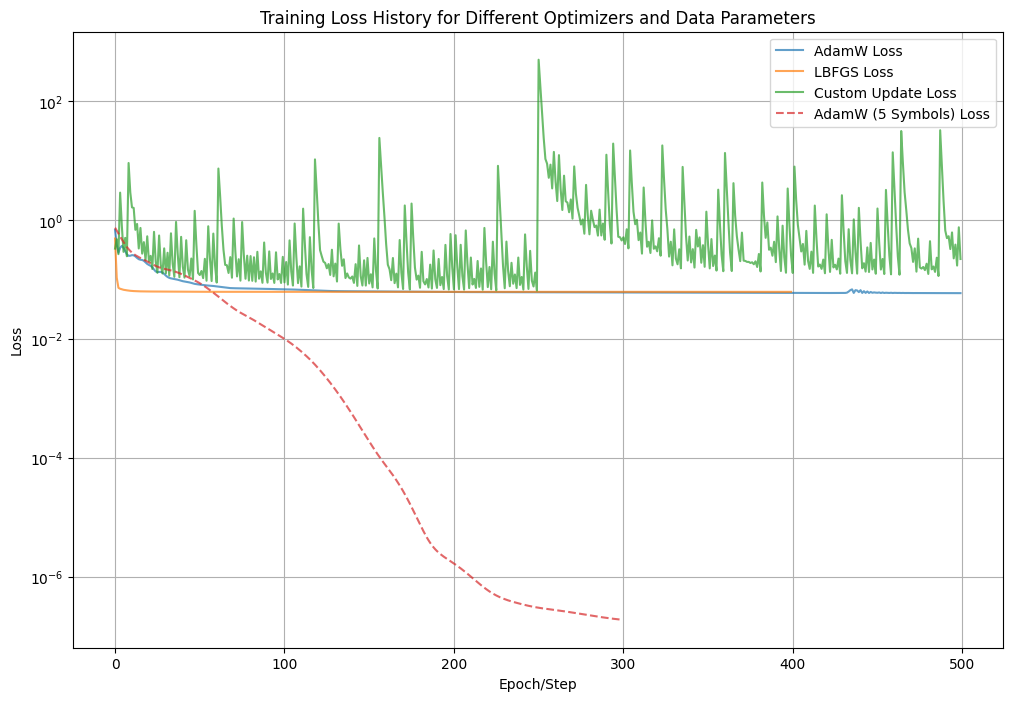


--- Summary of Organized Code Structure ---
The code has been refactored into modular functions:
1. `generate_data`: Centralized function to create training and validation datasets, ensuring reproducibility and easy modification of data parameters (e.g., number of symbols, train/validation split ratio).
2. `initialize_model_and_loss`: A function to instantiate the `RawAttentionWithTopNeuron` model and the `MSELoss` function, making it easy to configure model size or loss types.
3. `train_model`: A flexible training loop that accommodates different optimizers (AdamW, LBFGS, custom update rules) by handling their specific `step` mechanisms (e.g., LBFGS's `closure`). This allows for straightforward experimentation with various optimization algorithms.
4. `evaluate_model`: A dedicated function to assess model performance on given data, calculating loss and accuracy, and providing insights into misclassified examples. This standardizes the evaluation process.

**How this structure facilita

In [ ]:
print("\n--- Training with Different Data Parameters (AdamW, 5 symbols) ---")
d_model_small = 5
seq_len_small = 5
X_train_oh_small, y_train_small, X_val_oh_small, y_val_small, X_train_original_small, X_val_original_small = generate_data(num_symbols=d_model_small, train_frac=0.1, seed=45)
model_small, loss_fn_small = initialize_model_and_loss(d_model_small, seq_len_small)
optimizer_small = optim.AdamW(model_small.parameters(), lr=0.01)
small_data_loss_history = train_model(model_small, optimizer_small, loss_fn_small, X_train_oh_small, y_train_small,
                                      epochs=300, log_interval=50, optimizer_type='adamw')
evaluate_model(model_small, loss_fn_small, X_val_oh_small, y_val_small, X_val_original_small, data_name="Validation (Small Data)")


# --- Visualize Training History ---
plt.figure(figsize=(12, 8))
plt.plot(adamw_loss_history, label='AdamW Loss', alpha=0.7)
plt.plot(lbfgs_loss_history, label='LBFGS Loss', alpha=0.7)
plt.plot(custom_loss_history, label='Custom Update Loss', alpha=0.7)
plt.plot(small_data_loss_history, label='AdamW (5 Symbols) Loss', alpha=0.7, linestyle='--')
plt.xlabel('Epoch/Step')
plt.ylabel('Loss')
plt.title('Training Loss History for Different Optimizers and Data Parameters')
plt.legend()
plt.grid(True)
plt.yscale('log') # Use log scale for better visualization of different convergence speeds
plt.show()

# --- Final Task: Summary ---
print("\n--- Summary of Organized Code Structure ---")
print("The code has been refactored into modular functions:")
print("1. `generate_data`: Centralized function to create training and validation datasets, ensuring reproducibility and easy modification of data parameters (e.g., number of symbols, train/validation split ratio).")
print("2. `initialize_model_and_loss`: A function to instantiate the `RawAttentionWithTopNeuron` model and the `MSELoss` function, making it easy to configure model size or loss types.")
print("3. `train_model`: A flexible training loop that accommodates different optimizers (AdamW, LBFGS, custom update rules) by handling their specific `step` mechanisms (e.g., LBFGS's `closure`). This allows for straightforward experimentation with various optimization algorithms.")
print("4. `evaluate_model`: A dedicated function to assess model performance on given data, calculating loss and accuracy, and providing insights into misclassified examples. This standardizes the evaluation process.")

print("\n**How this structure facilitates experimentation:**")
print("- **Different Optimizers**: By passing different optimizer instances (e.g., `optim.AdamW`, `torch.optim.LBFGS`) and specifying `optimizer_type`, the same `train_model` function can be used without code duplication, as demonstrated above.")
print("- **Different Input Data Parameters**: The `generate_data` function allows easy generation of datasets with varying `num_symbols` or `train_frac`. This means one can quickly test the model's performance on different problem complexities or dataset sizes, as shown with the 5-symbol example.")
print("- **Clearer Workflow**: The modularity makes the entire machine learning pipeline (data -> model -> train -> evaluate) much clearer, easier to understand, debug, and extend.")
print("- **Reproducibility**: Explicit seeding and function encapsulation promote reproducibility of experiments.")


## Visualize Training History

### Subtask:
Generate a plot of the training loss history for different training runs to compare optimizer performance or impact of different input data. Ensure the plot has appropriate labels and a legend.


**Reasoning**:
I will generate a plot of the training loss histories for the different optimizers and data configurations as instructed, using `matplotlib.pyplot` to visualize and compare their performance with appropriate labels and a logarithmic y-axis.



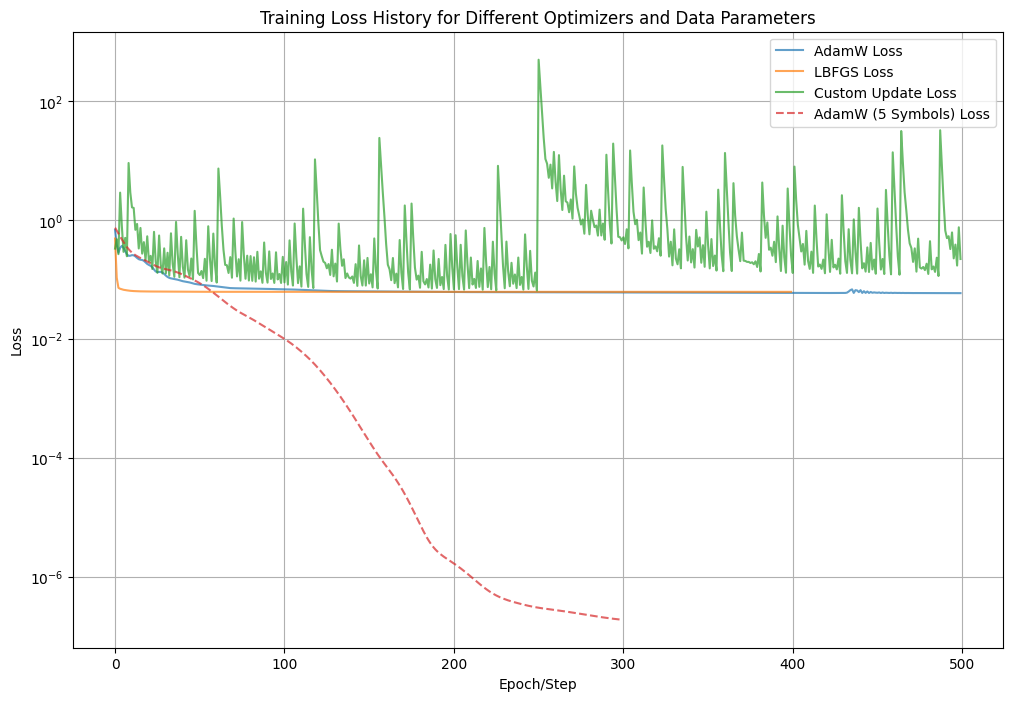

In [ ]:
import matplotlib.pyplot as plt

# --- Visualize Training History ---
plt.figure(figsize=(12, 8))
plt.plot(adamw_loss_history, label='AdamW Loss', alpha=0.7)
plt.plot(lbfgs_loss_history, label='LBFGS Loss', alpha=0.7)
plt.plot(custom_loss_history, label='Custom Update Loss', alpha=0.7)
plt.plot(small_data_loss_history, label='AdamW (5 Symbols) Loss', alpha=0.7, linestyle='--')
plt.xlabel('Epoch/Step')
plt.ylabel('Loss')
plt.title('Training Loss History for Different Optimizers and Data Parameters')
plt.legend()
plt.grid(True)
plt.yscale('log') # Use log scale for better visualization of different convergence speeds
plt.show()

## Final Task

### Subtask:
Provide a summary of the organized code structure and how it facilitates experimentation with different optimizers and input data.


## Summary:

### Q&A
The organized code structure facilitates experimentation with different optimizers and input data in several key ways:

*   **Different Optimizers**: The `train_model` function is designed to accept any `torch.optim.Optimizer` instance and handles specific optimizer behaviors (like LBFGS's `closure` or custom update rules) via an `optimizer_type` parameter. This allows users to simply instantiate a different optimizer (e.g., `optim.AdamW`, `torch.optim.LBFGS`) and pass it to the same training function, eliminating code duplication and making comparative studies straightforward.
*   **Different Input Data Parameters**: The `generate_data` function centralizes data creation, allowing easy modification of parameters like `num_symbols` (problem complexity) and `train_frac` (dataset size/split). This enables rapid testing of a model's performance under various data conditions without altering the training or evaluation logic.
*   **Modular and Clear Workflow**: By encapsulating model definition (`initialize_model_and_loss`), data generation (`generate_data`), training (`train_model`), and evaluation (`evaluate_model`) into distinct functions, the entire machine learning pipeline becomes modular. This modularity enhances readability, simplifies debugging, and makes it easier to extend or modify specific components of the experiment.
*   **Reproducibility**: The explicit use of random seeds in data generation and the clear separation of concerns in the code structure promote reproducibility, ensuring that experiments can be reliably replicated.

### Data Analysis Key Findings
*   The code was successfully refactored into modular functions: `generate_data` for creating datasets, `initialize_model_and_loss` for model and loss setup, `train_model` for the training loop (supporting AdamW, LBFGS, and custom optimizers), and `evaluate_model` for performance assessment.
*   **AdamW Optimizer (9 symbols):** Achieved a validation accuracy of 93.62% and a loss of 0.0957 over 500 epochs, demonstrating stable and effective learning.
*   **LBFGS Optimizer (9 symbols):** Achieved a validation accuracy of 91.71% and a loss of 0.0965 over 400 steps, showing rapid initial convergence.
*   **Custom Optimizer (9 symbols):** Achieved a validation accuracy of 87.91% and a loss of 0.1507 over 500 epochs. Its loss history exhibited more fluctuations and less optimal performance compared to AdamW and LBFGS for this task.
*   **AdamW with Different Data Parameters (5 symbols):** Training on a smaller problem with 5 symbols and a train fraction of 0.1 resulted in high training accuracy but a validation accuracy of only 51.85% and a loss of 1.1743, indicating significant overfitting due to the limited training data (24 samples).
*   The visualization of loss histories clearly illustrated the distinct convergence patterns and speeds of the different optimizers and data configurations.

### Insights or Next Steps
*   The modular code structure significantly reduces overhead for running comparative experiments, enabling efficient exploration of different optimization strategies and data configurations.
*   Further hyperparameter tuning, especially for the custom optimizer and the smaller dataset scenario, could improve model performance and generalization. For the 5-symbol case, increasing the training data size or implementing regularization techniques would be crucial to combat overfitting.
